Let's explore whether we can discover information about private real estate investors from the ACRIS database made open by NYC Open Data. Can we figure out a firm's corporate strategy? We'll use The Praedium Group (http://praediumgroup.com/), a large NYC real estate investor, as a test subject.

In [1]:
# Imports

import math
import statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
%matplotlib inline
import datetime as dt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Load into pandas dataframe
path='search-praedium.csv'
df_sql = pd.read_csv(path)

df_sql['doctype'] = df_sql['doctype'].str.strip()
df_sql['recorded'] =  pd.to_datetime(df_sql['recorded'], infer_datetime_format=True)
df_sql['docdate'] =  pd.to_datetime(df_sql['docdate'], infer_datetime_format=True)

# Drop rows in which doctype is not defined
df_sql.dropna(subset=['doctype'], inplace=True)
# Drop rows in which the docdate is 1900
df_sql.drop(df_sql[pd.DatetimeIndex(df_sql.docdate).year<1910].index, inplace=True)

In [ ]:
# Map each purchase to its sale

# Create two tables from data; one that has purchases, and one that has sales
df_purchases = df_sql[(df_sql['partype']==2) & ((df_sql['doctype']=='DEED') | (df_sql['doctype']=='DEEDO'))]
df_sales     = df_sql[(df_sql['partype']==1) & ((df_sql['doctype']=='DEED') | (df_sql['doctype']=='DEEDO'))]
df_purchases.sort_values(by=['docdate'], ascending=True, inplace=True)
df_sales.sort_values(by=['docdate'], ascending=True, inplace=True)

# Remove duplicates
df_purchases.drop_duplicates(subset=['unkey', 'partype', 'docdate', 'docamt', 'recorded', 'boro', 'BBL'], inplace=True)
df_sales    .drop_duplicates(subset=['unkey', 'partype', 'docdate', 'docamt', 'recorded', 'boro', 'BBL'], inplace=True)

# Remove when the company sold to itself
purchase_sale = df_purchases[df_purchases['unkey'].isin(df_sales['unkey'])].index
sale_purchase = df_sales[df_sales['unkey'].isin(df_purchases['unkey'])].index
df_purchases.drop(purchase_sale, inplace=True)
df_sales.drop(sale_purchase, inplace=True)

# Remove transfers
df_purchases.drop(df_purchases[df_purchases.docamt < 1000].index, inplace=True)
df_sales.drop(df_sales[df_sales.docamt < 1000].index, inplace=True)

df_all_deeds = pd.concat([df_purchases, df_sales])

# Merge purchase and sale tables
df_combo_purchases_sales_left = pd.merge(df_purchases, df_sales, on='BBL', how='left')
# Drop rows where the company bought and sold a property on the same date (indicating a transfer)
df_combo_purchases_sales_left.drop(df_combo_purchases_sales_left[df_combo_purchases_sales_left.docdate_x==df_combo_purchases_sales_left.docdate_y].index, inplace=True)

# The following does the job identically, but it might work better if a company is involved in multiple sales and repurchases of the same property
# # Merge purchase and sale tables
# df_purchases['docdate_x'] = df_purchases['docdate']
# df_sales['docdate_y'] = df_sales['docdate']
# df_combo_purchases_sales_left = pd.merge_asof(df_purchases, df_sales, on='docdate', by='BBL', direction='forward', allow_exact_matches=False)

In [7]:
# User options for plotting

fontsize = 18
color_palette = ['r', 'b']

In [8]:
# Do some calculations for the plotting of purchase/sales

df_combo_purchases_sales_left_sorted = df_combo_purchases_sales_left.sort_values(by=['docdate_x', 'docdate_y', 'unkey_x', 'unkey_y'], ascending=False)
bdate, edate, labels, purchase, sale, profit, annualized_growth, years_held_unsold, years_held_sold, colors = [], [], [], [], [], [], [], [], [], []
i = 0
for index, row in df_combo_purchases_sales_left_sorted.iterrows():
    # purchase date
    bdate.append(row['docdate_x'].to_pydatetime())
    # sale date (if it doesn't exist, the property is still owned)
    if pd.isnull(row['docdate_y']): #Property was purchased but has not been sold
        edate.append(dt.datetime.today())
        years_held_unsold.append((dt.datetime.today() - row['docdate_x']).total_seconds()/(60*60*24*365.25))
        colors.append(color_palette[0])
    else: #Property was purchased and sold
        edate.append(row['docdate_y'].to_pydatetime())
        years_held_sold.append((row['docdate_y'] - row['docdate_x']).total_seconds()/(60*60*24*365.25))
        colors.append(color_palette[1])
    # BBL for labeling the y-axis of the plot.
    labels.append(row['BBL'])
    # If the BBL appears multiple times (e.g., the owner bought and sold a property, and then bought it again), an asterisk will appear next to its label.
    if len(df_combo_purchases_sales_left_sorted[df_combo_purchases_sales_left_sorted['BBL'] == labels[i]]) > 1:
        labels[i] = '* ' + labels[i]
    # purchase price
    purchase.append(row['docamt_x'])
    # sales price
    sale.append(row['docamt_y'])
    # calculate profit and annualized growth rate
    profit.append(row['docamt_y'] - row['docamt_x']) 
    years = (edate[i] - bdate[i]).days/365.25
    try:
        annualized_growth.append(((sale[i]/purchase[i])**(1/years) - 1)*100)
    except:
        annualized_growth.append('no purchase price')
    i+=1

edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]

In [14]:
# Do some calculations for the plotting of purchase/sales per boro

df_all_deeds_sorted = df_all_deeds.sort_values(by=['docdate'], ascending=True)
date = {}
owns = {}

# Initialize list with 0
first_date = df_all_deeds_sorted.iloc[0]['docdate']
for boro in df_all_deeds_sorted['boro'].unique():
    date[boro] = [first_date]
    owns[boro] = [0]
    
for index, row in df_all_deeds_sorted.iterrows():
    if row['partype']==2:
        date[row['boro']].append(row['docdate'].to_pydatetime())
        owns[row['boro']].append(owns[row['boro']][-1]+1)
    if row['partype']==1:
        date[row['boro']].append(row['docdate'].to_pydatetime())
        owns[row['boro']].append(owns[row['boro']][-1]-1)
        
# Bring all lists to last date given
last_date = df_all_deeds_sorted.iloc[-1]['docdate']
for boro in df_all_deeds_sorted['boro'].unique():
    date[boro].append(last_date)
    owns[boro].append(owns[boro][-1])

Let's see whether they've been expanding in the NYC market or trying to get out of the marker. Which boroughs are they most interested in?

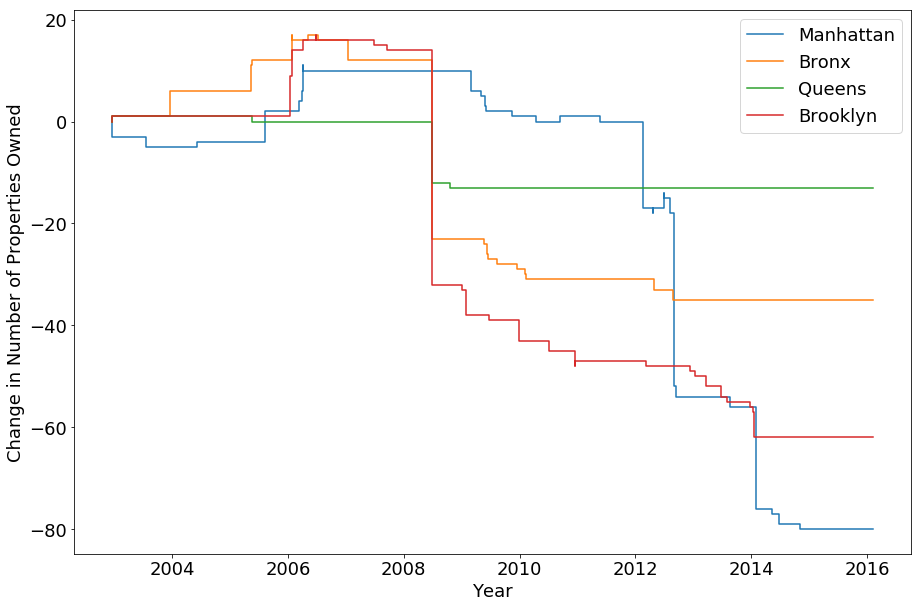

In [15]:
# Plot changes in ownernship per boro over time

fontsize=18
dict_number_to_boro = {1: "Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten island"}

fig, ax = plt.subplots(figsize=(15,10))
for boro in df_all_deeds_sorted['boro'].unique():
    plt.step(date[boro], owns[boro], '-', label=dict_number_to_boro[boro])
plt.xlabel('Year', fontsize=fontsize)
plt.ylabel('Change in Number of Properties Owned', fontsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 
plt.legend(fontsize=fontsize)
plt.savefig('borough-ownership-timeline.png')
plt.show()

It looks like they have been largely in a liquidation/sales mode since mid-2008, when they started a large selloff in their Brooklyn, Bronx, and Queens properties, followed by selloffs in their Manhattan properties in 2012 and 2014.

We'll plot all the firm's purchases we found in the database to see what properties they bought and sold, when they did this, and how much profit they made off of their sales.

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


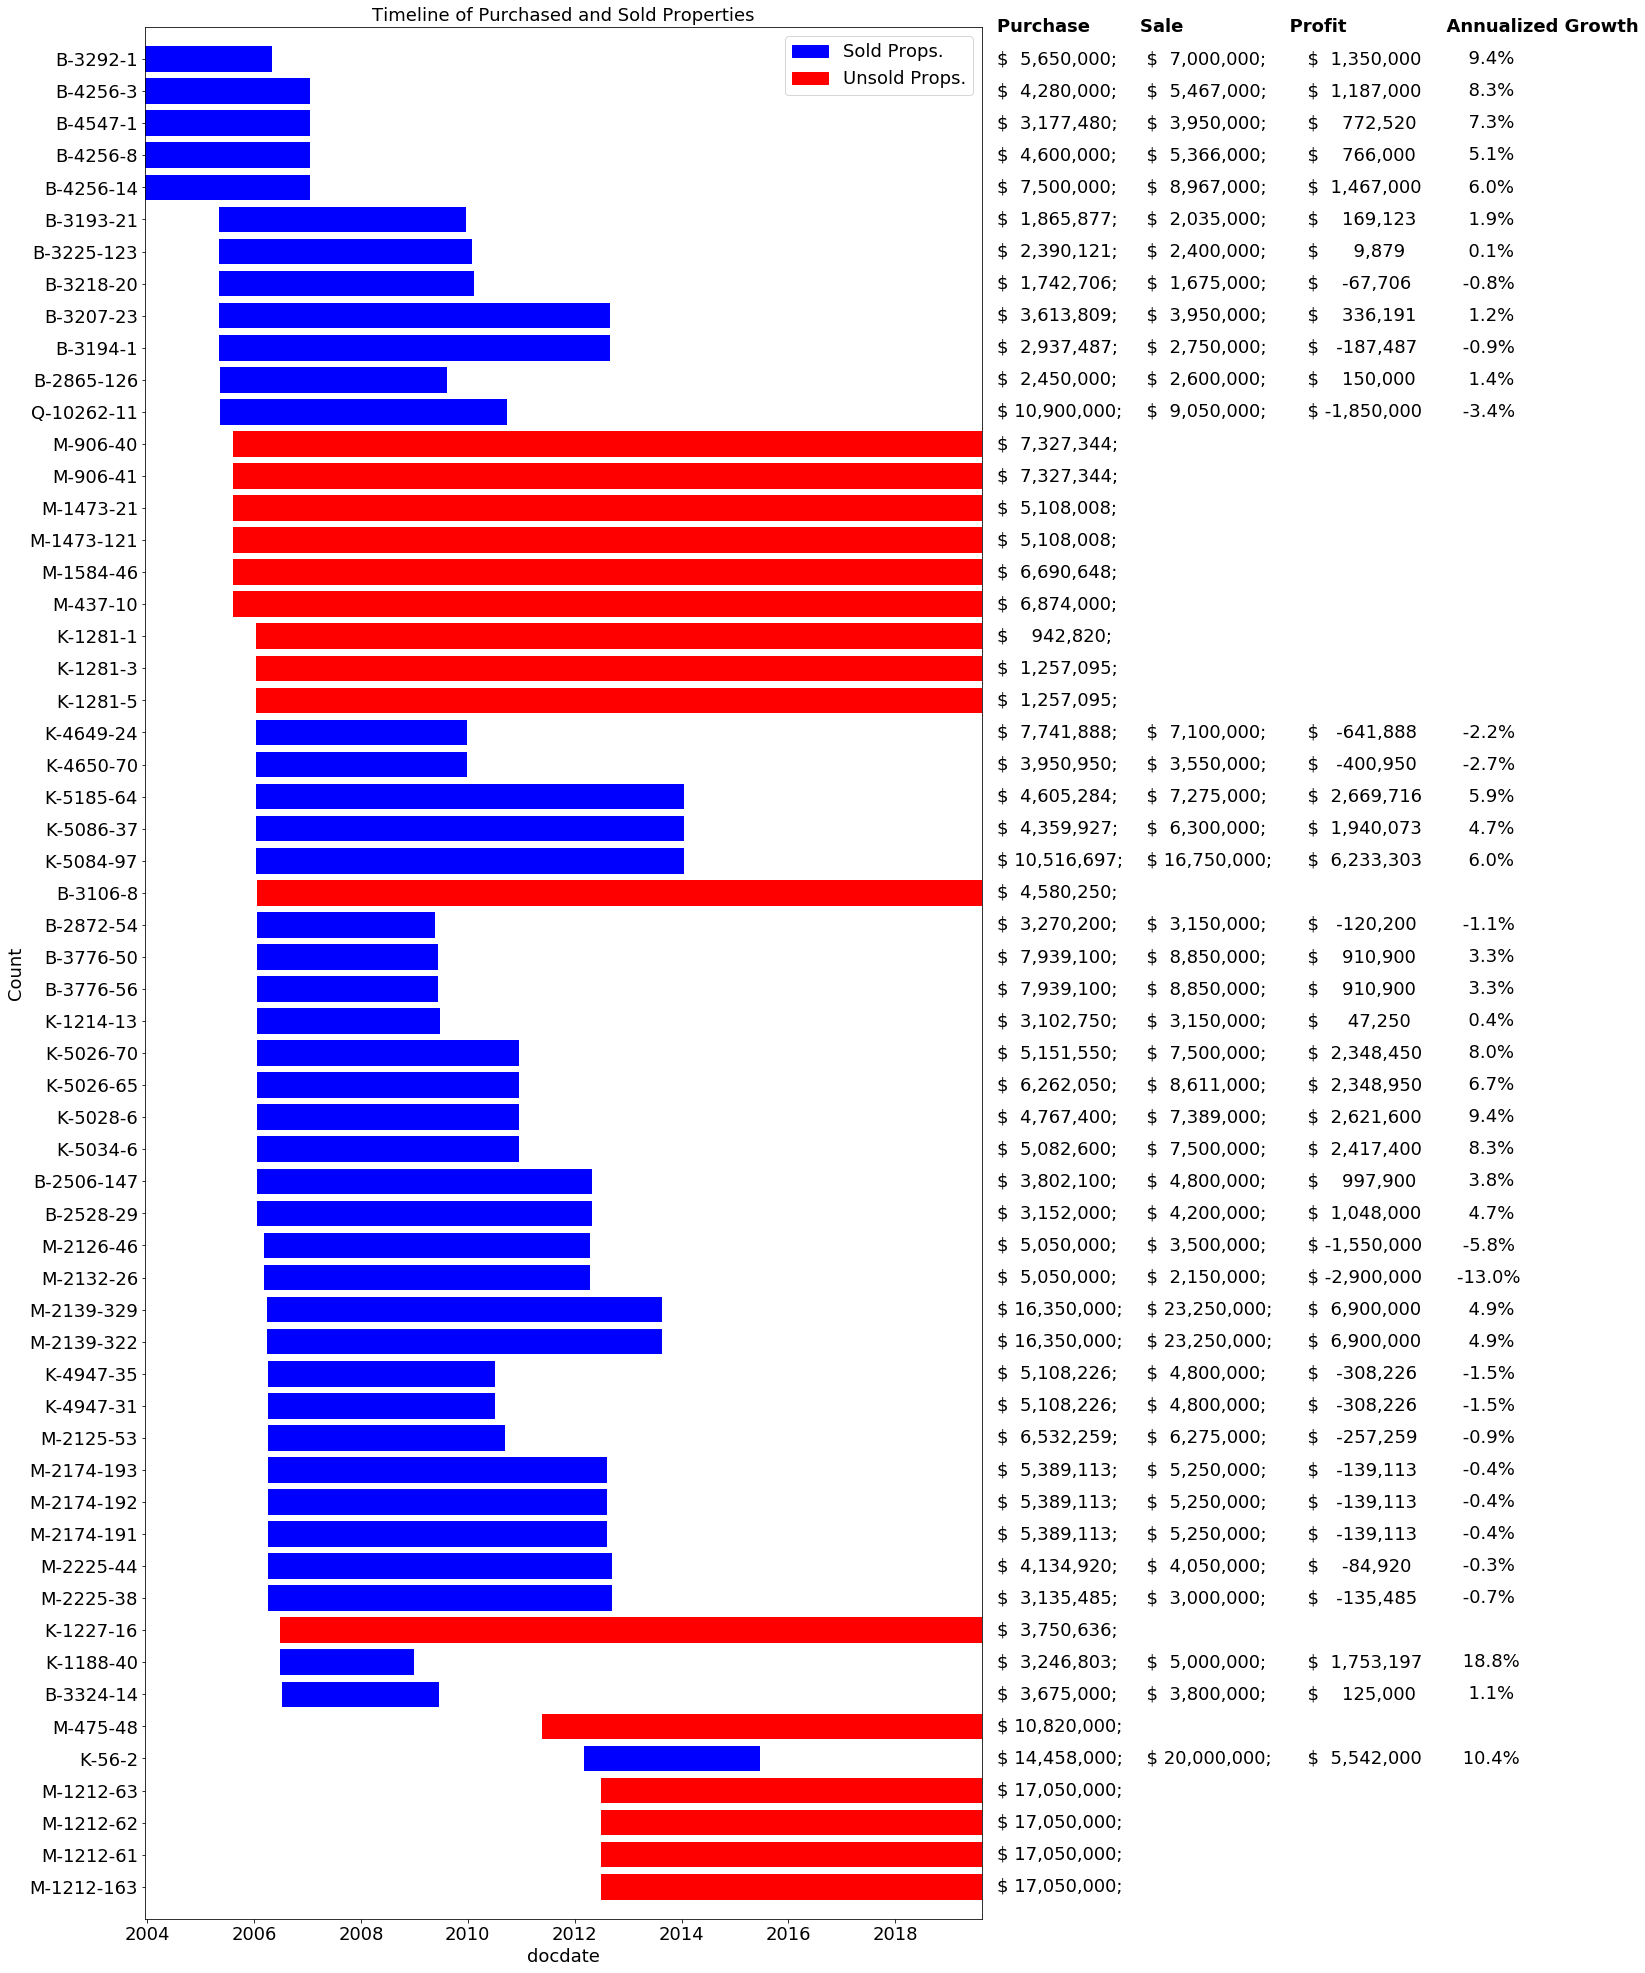

In [9]:
# Plot purchase/sales history bar plot

offset_text = 100

fig, ax = plt.subplots(figsize=(15,0.6*len(bdate)))
ypos = range(len(bdate))
ax.barh(ypos, edate - bdate, left=bdate, height=0.8, tick_label=labels, align='center', color=colors)
ax.xaxis_date()
plt.xlim(right=dt.datetime.today())
plt.ylim((-1, ypos[-1]+1))
ax.text(ax.get_xlim()[1]+offset_text, ax.get_ylim()[1], '{}        {}                 {}                {}'.format('Purchase', 'Sale', 'Profit','Annualized Growth'), va='center', fontweight='bold', fontsize=fontsize)
for i in range(len(bdate)):
    if purchase[i]!=0 and not math.isnan(purchase[i]):
        ax.text(ax.get_xlim()[1]+offset_text, ypos[i], '${:11,.0f};'.format(purchase[i]), va='center', fontsize=fontsize)
    if sale[i]!=0 and not math.isnan(sale[i]):
        ax.text(ax.get_xlim()[1]+offset_text, ypos[i], '                          ${:11,.0f};'.format(sale[i]), va='center', fontsize=fontsize)
    if purchase[i]!=0 and sale[i]!=0 and not math.isnan(purchase[i]) and not math.isnan(sale[i]):
        ax.text(ax.get_xlim()[1]+offset_text, ypos[i], '                                                      ${:11,.0f}'.format(profit[i]), va='center', fontsize=fontsize)
        if purchase[i]!=sale[i]:
            ax.text(ax.get_xlim()[1]+offset_text, ypos[i], '                                                                                {:5.1f}%'.format(annualized_growth[i]), va='center', fontsize=fontsize)
    else:
        pass
plt.xlabel('docdate', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 
plt.legend(handles=[mpatches.Patch(color=color_palette[1], label='Sold Props.'), mpatches.Patch(color=color_palette[0], label='Unsold Props.')], fontsize=fontsize)
plt.title('Timeline of Purchased and Sold Properties', fontsize=fontsize)
plt.savefig('property-sales-history-bar.png', bbox_inches="tight")
plt.show()

# Note that some properties are bought/sold in blocks, so the profit is not always accurate for a given property. e.g., if M-11-21 was bought with 3 other properties for $1M and sold with 5 other properties for $3M, we'd show the profit for M-11-21 being $2M (which would also appear with the other properties in the two buy/sell blocks). The user should be notified about this.
# Note also that this does not include properties that might show up as currently owned if no DEEDs were entered that the property was purchased. Since we oftentimes see properties being sold in SQL without there being a purchase, this might happen a lot

It looks like Praedium is comfortable selling their properties without realizing much of a gain on them, as since the 2008 market crash, a lot of their properties are being sold with a negative annualized growth.

By plotting a histogram of how long the group held onto their properties, we can figure out what their usual hold strategy is. Are they a "buy and hold" company, or do they buy and try to flip quickly?

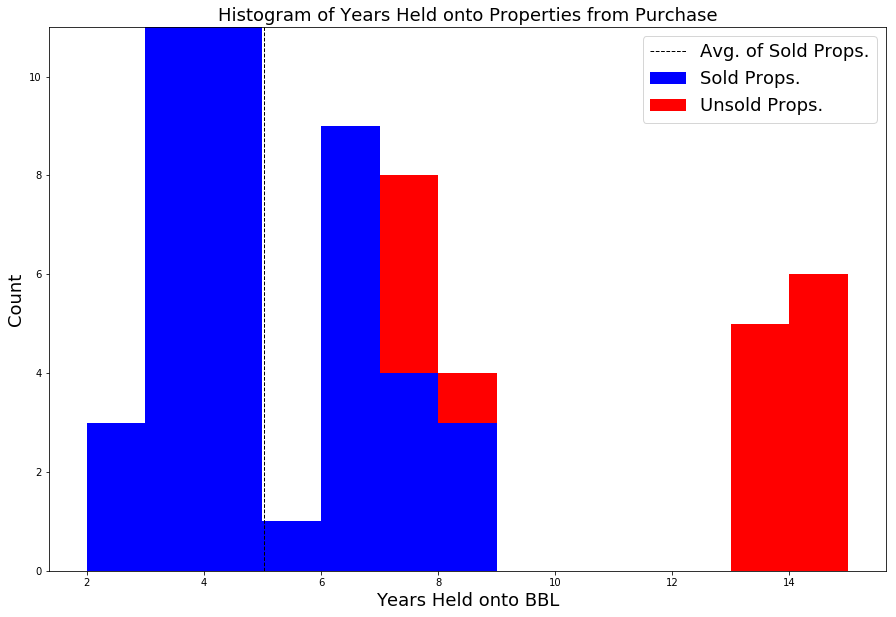

In [10]:
# Plot purchase/sales years held  histogram

years_held = [years_held_sold, years_held_unsold]
if years_held_sold and years_held_unsold:
    years_held_min = min(min(years_held_sold), min(years_held_unsold))
    years_held_max = max(max(years_held_sold), max(years_held_unsold))
elif years_held_sold:
    years_held_min = min(years_held_sold)
    years_held_max = max(years_held_sold)
elif years_held_unsold:
    years_held_min = min(years_held_unsold)
    years_held_max = max(years_held_unsold)
bins = list(np.arange(math.floor(years_held_min), math.ceil(years_held_max)+1, 1))

plt.figure(figsize=(15,10))
plt.hist(years_held, bins=bins, stacked=True, color=[color_palette[1], color_palette[0]])
plt.axvline(statistics.mean(years_held_sold), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Years Held onto BBL', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 
plt.legend(['Avg. of Sold Props.', 'Sold Props.', 'Unsold Props.'], fontsize=fontsize)
plt.title('Histogram of Years Held onto Properties from Purchase', fontsize=fontsize)
plt.savefig('years-held-histogram.png')
plt.show()

They appear to operate with two strategies relating to their hold-periods. They typically hold properties for 2-9 years (averaging 5 years) before selling them, but nonetheless, they have a several properties that they’ve been holding for going on 14 years now.